In [3]:
# https://drive.google.com/file/d/1J6Xj7PS-8H-0uPBHyIQHfY8eCJjsJ12I/view

!pip install tensorflow==1.15.0
import tensorflow as tf
print('Current tensorflow version: ',tf.__version__)
from tensorflow import keras
import numpy as np
import json 
import matplotlib.pyplot as plt
from scipy import stats
from collections import defaultdict

from google.colab import files

Current tensorflow version:  1.15.0


In [8]:
# upload the json file form your local machiene
uploaded = files.upload()

Saving training_data_HANDS.json to training_data_HANDS (1).json


In [20]:

class Data:

    def __init__(self, x, y):

        self.Y = dict(zip(y,[i for i in range(len(y))])) 
        self.x = X(x)
        self.y = Y(y)
        self.zscors = []
        self.angles = [] 
        self.correct_shape = False
        self.seq = []

    def seq_generator(self,letter,n):
      N = self.Y[letter]
      assert n <= self.y.counts[N], "invalid number"
      curr = 0
      for i in range(0,N):
        curr += self.y.counts[i]
      x = self.zscors[curr + n]
      return x

    def reshape(self):
      
      # reshaping X
      assert self.x.reshaped != True, "Already in a correct shape"
      x = []
      for i in range(0,len(self.x.ORIG)):
        x_data = []
        for j in range(0,len(self.x.ORIG[i])):
          x_data = self.x.points[i][j]
          assert len(x_data) == 63, "ERROR NOT 63, IS {}\nData structure: {}".format(len(x_data), self.x.points[i][j])
          x.append(x_data)
      self.x.points = np.array(x)
      self.x.reshaped = True
      
      # reshaping Y
      assert self.x.reshaped == True, "X not reshaped"
      y = []
      for i in range(0,len(self.y.letters)):
        count = 0
        for j in range(0,len(self.x.ORIG[i])):
          y.append(str(i))
          count += 1  
        self.y.counts.append(count)
      self.y.values = np.array(y)
      self.y.reshaped = True
      self.correct_shape = True


    def z_norm(self):
      assert self.correct_shape == True, "Not in the correct shape"
      assert len(self.zscors) == 0, "Alredy Contains z-scors"
      for i in range(0,len(self.x.points)):
        xs,ys = [],[]
        xs = [self.x.points[i][j] for j in range(0,63,3)]
        ys = [self.x.points[i][j] for j in range(1,63,3)]
        zs = [self.x.points[i][j] for j in range(2, 63, 3)]
        zx,zy,zz = 0,0,0
        zx, zy,zz = stats.zscore(xs), stats.zscore(ys), stats.zscore(zs)
        zscors = []
        for j in range(0,21):
          zscors.append(zx[j])
          zscors.append(zy[j])
          zscors.append(zz[j])
        self.zscors.append(zscors)

    def remove(self,n): # *args and **kwargs should be used
      if(type(n)==int):
        remove_p,remove_z = [],[]
        self.x.points = np.delete(self.x.points,n,axis=0)
        self.zscors = np.delete(self.zscors,n,axis=0)
        self.y.values = np.delete(self.y.values,n,axis=0)
        print(type(n))
      
      else:
        for i in range(0,len(n)):
          assert self.correct_shape == True, "Reshape it first" ### NOT TESTED
          remove_p,remove_z = [],[]
          self.x.points = np.delete(self.x.points,n[i],axis=0)
          self.zscors = np.delete(self.zscors,n[i],axis=0)
          self.y.values = np.delete(self.y.values,n[i],axis=0)
    
class Train(Data):
    pass
  
class Test(Data):
    pass

class X():

  def __init__(self,values):
    self.points = values
    self.reshaped = False
    self.ORIG = values

class Y():

  def __init__(self,values):
    self.letters = values
    self.values = []
    self.reshaped = False
    self.counts = []
    self.ORIG = values
    
class Z():

  def __init__(self,values):
    self.letters = values
    self.values = []
    self.reshaped = False
    self.counts = []
    self.ORIG = values

# Global Functions

def history_plot(my_model):
  print([ i for i in my_model.history.keys()])
  # Plot training & validation accuracy 
  plt.plot(my_model.history['acc'])
  plt.plot(my_model.history['val_acc'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  # Plot training & validation loss 
  plt.plot(my_model.history['loss'])
  plt.plot(my_model.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

def plot_predict(predictions):
  # dict of wrong predictioins
  dict_flaws={}
  for i in range(0,len(predictions)):
    pp = np.argmax(predictions[i])
    AA = int(test.y.values[i])
    if (pp != AA):
      dict_flaws.update({str(i):[pp,AA]})

  # grouped by the predected letter =>>>>> dict{predicted letter:[[picture number,Accuracy][][]...]}
  flaws = defaultdict(list) 
  for key, val in sorted(dict_flaws.items()): 
      flaws[val[0]].append([key,val[1]]) 
  print("The error frequency")
  for i in flaws.keys():
    print(str(test.y.letters[i]),': ',len(flaws[i]))
  print('\n\n',"In Total: ",len(flaws),'wrong predictions \n\n')

  # plot wrong predictions
  for i in flaws.keys():
    for j in range(0,len(flaws[i])):
      A = flaws[i][j][1]
      n = int(flaws[i][j][0])
      xss = [-1*test.zscors[n][s] for s in range(0,42,2)]
      yss = [-1*test.zscors[n][s] for s in range(1,42,2)]
      if(j == 0):
        print('Falsely predicted: '+str(test.y.letters[i]))
        print('\n')
      # plt.subplot(1,len(flaws[i]),j+1)  
      plt.figure(figsize=(3,3))
      plt.plot(xss,yss,'ro')
      plt.title('Actually:  '+ str(test.y.letters[A]) + '     (' +str(n)+')')
      # plt.suptitle('predicted:'+str(test.y.letters[i])+', Actually '+str(test.y.letters[A ])+ '\n'+ " "+'\n'+" "+ '\n')
      plt.tight_layout()
      colors = ['red','green','purple','brown','black']
      for j in range(0,20,4): 
        plt.plot([xss[0],xss[j+1]],[yss[0],yss[j+1]],'k-',color = colors[int(j/4)])
        for k in range(0,3):
          plt.plot([xss[k+j+1],xss[k+2+j]],[yss[k+j+1],yss[k+2+j]],'k-',color = colors[int(j/4)]) 
    plt.show()
    print('\n\n')



def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        # Graph -> GraphDef ProtoBuf
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph

In [10]:
filename = list(i for i in uploaded.keys())[0]
enc = uploaded[filename] 
dec = json.loads(enc.decode('utf-8'))
x = [i for i in dec.values()]
y = [i for i in dec.keys()]

# the train/test split (one time run)
ytest = y
xtest = []
split = False
for i in range(0,len(x)):
  l = int(len(x[i])*20/100) # 20% of the data for testing
  xt = []
  for j in range(0,l):
    r = np.random.randint(low = 0, high = len(x[i]))
    xt.append(x[i].pop(r))
  xtest.append(xt)


In [11]:
# initialize train and test
train = Train(x,y)
print("Training data object")
test = Test(xtest,ytest)
print("Validation data object")


train.reshape()
test.reshape()
train.z_norm()
test.z_norm()
print("Normalized")

Training data object
Validation data object
Normalized


In [12]:
print(train.Y) # enumerated labels

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'O': 13, 'P': 14, 'Q': 15, 'R': 16, 'S': 17, 'T': 18, 'U': 19, 'V': 20, 'W': 21, 'X': 22, 'Y': 23}


In [ ]:
# points and zscors
import tensorflow as tf
class ModelAttempt:
  def __init__(self, epochs, layers, train, test):
    self.epochs = epochs
    self.layers = layers
    self.keras_layers = []
    self.train = train
    self.test = test
    [self.keras_layers.extend(x.layer) for x in layers]
    self.model = keras.models.Sequential(self.keras_layers)
  def run(self):
    self.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    self.model.fit(np.array(self.train.zscors), np.array(self.train.y.values), validation_data=(np.array(self.test.zscors), np.array(self.test.y.values)), epochs=self.epochs, shuffle=True, verbose=0)
    self.loss, self.accuracy = self.model.evaluate(np.array(self.test.zscors), np.array(self.test.y.values), verbose=0,)
    return self.accuracy

  def __str__(self):
    return "[x{}]".format(self.epochs) + str(self.layers)
  def __repr__(self):
    return str(self)

class Layer:
    def __init__(self, density, dropout, activation):
      self.density = density
      self.dropout = dropout
      self.activation = activation
      self.layer = [
                    keras.layers.Dense(density, activation=activation),
                    keras.layers.Dropout(dropout)
                    ]
    def __str__(self):
      return self.activation + "(x{})-{}".format(self.density, self.dropout)

    def __repr__(self):
      return str(self)
class InputLayer:
  def __init__(self):
    self.layer = [
      keras.layers.Flatten(input_shape=(63,))
    ]
  def __str__(self):
    return "Input"
class OutputLayer:
  def __init__(self):
    self.layer = [
      keras.layers.Dense(24, activation='softmax')
    ]
  def __str__(self):
    return "Output"
def singleLayerGenerator():
  START_DENSITY = 1
  END_DENSITY = 1000
  DENSITY_STEPS = 10

  START_DROPOUT = int(0.00 * 100 )# Dropouts are multiplied by 100 because cannot range through decimals
  END_DROPOUT = int(0.4 * 100)
  DROPOUT_STEPS = int(.05 * 100)

  ACTIVATION_TYPES = ["relu", "tanh", "sigmoid", "exponential"]




  for density in range(START_DENSITY, END_DENSITY, DENSITY_STEPS):
    for dropout in range(START_DROPOUT, END_DROPOUT, DROPOUT_STEPS):
      dropout /= 100
      for activation in ACTIVATION_TYPES:
        yield Layer(density, dropout, activation)

def multipleLayerGenerator(layers_per_size):
  import random
  LAYER_COUNT_MIN = 1
  LAYER_COUNT_MAX = 4

  POTENTIAL_LAYERS = []
  for layer in singleLayerGenerator():
    POTENTIAL_LAYERS.append(layer)
  for layer_count in range(LAYER_COUNT_MIN, LAYER_COUNT_MAX):
    for attempt in range(0, layers_per_size):
      layers = [InputLayer(),]
      for l in range(0, layer_count):
        layers.append(random.choice(POTENTIAL_LAYERS))
      layers.append(OutputLayer())
        
      yield layers


RESULTS = {
    
}
def runModel(givenModel):
   result = givenModel.run()
   print("{}% {}".format(result, givenModel))
   RESULTS[givenModel] = result

MODELS = []
EXCEPTION_MODELS = []

for x in multipleLayerGenerator(100):
  layers = x
  try:
    MODELS.append(ModelAttempt(7, layers, train, test))
  except:
    EXCEPTION_MODELS.append([layers])

print("{} models formed".format(len(MODELS)))


for model in MODELS:
  runModel(model)
print("BEST MODEL FOUND:", max(RESULTS, key=RESULTS.get))

print("RESULTS:", RESULTS)




# .h5 (Keras) to .pb (Tensorflow)
# from keras import backend as K
# from tensorflow.python.framework.graph_util import convert_variables_to_constants
# tf.keras.backend.set_learning_phase(0)
# model = tf.keras.models.load_model("./model/keras_model.h5")
# frozen_graph = freeze_session(K.get_session(),
#                               output_names=[out.op.name for out in model.outputs])



In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from datetime import datetime

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import uuid
import os
import json


class GoogleDriveDatabase:
  def __init__(self, drive, DATABASE_GID:str):
    assert isinstance(DATABASE_GID, str)
    self.folders = {}
    self.drive = drive
    folder_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(DATABASE_GID)}).GetList()
    for file in folder_list:
      if file['mimeType'] == "application/vnd.google-apps.folder":
        self.folders[file['title']] = file['id']
    print("{} folders loaded".format(len(self.folders.keys())))
  def upload(self, filename, character, fileType):
    assert isinstance(filename, str)
    assert isinstance(character, str)
    assert isinstance(fileType, str)
    FILETYPE_MIME_MAP = {
        "jpeg" : "image/jpeg",
        "json" : "application/json",
        "zip" : "application/zip",
        "pickle" : "application/octet-stream"
    }
    assert fileType in FILETYPE_MIME_MAP.keys(), "fileType must be one of the following: {}".format(fileType)
    assert os.path.isfile(filename), "{} does not exist as a file".format(filename)
    assert self.checkFolder(character), "{} is not a valid character. Pick from list: \n{}".format(character, tuple(self.folders.keys()))
    file = self.drive.CreateFile({
        "title" :  os.path.split(filename)[1],
        "mimeType" : FILETYPE_MIME_MAP[fileType],
        "parents" : [{"id" : self.folders[character]}]
    })
    file.SetContentFile(filename)
    file.Upload()
    os.remove(filename)
    print("uploaded and deleted {}".format(filename))

  @staticmethod
  def FILE_EXTENSIONS() -> list:
    return [".jpg", ".jpeg", ".png", ".zip", ".json"]

  def getFiles(self, character) -> list:
    return [
      x for x in self.drive.ListFile({'q': "'{}' in parents and trashed=false".format(self.folders[character])}).GetList()
      if x['mimeType'] != "application/vnd.google-apps.folder" 
    ]
  def download_file_name(self, file_name):
      if not any(extension in file_name for extension in GoogleDriveDatabase.FILE_EXTENSIONS()):
        file_name += ".jpg"
      return file_name
  def download_file(self, file, folder:str, **kwargs) -> str:
      check_already_exist = kwargs.get("check_local", False)
      file_name = os.path.join(folder, file['title'])
      file_name = self.download_file_name(file_name)
      if check_already_exist:
        local_files = [os.path.join(folder, file) for file in os.listdir(folder)]
        if file_name in local_files:
          return file_name
      file.GetContentFile(file_name)
      print("downloaded", file_name)
      return file_name

  def download(self, character:str,folder:str):
    file_list = self.getFiles(character)
    os.makedirs(folder, exist_ok=True)
    returnlist = []
    
    for file in file_list:
      returnlist.append(self.download_file(file, folder, check_local=True))


    return tuple(returnlist)

  def checkFolder(self, name):
    assert isinstance(name, str)
    return name in self.folders.keys()


MODELS.sort(key=lambda x: x.accuracy, reverse=True)

for x in range(0, 10): # Top 10 new results
  model = MODELS[x]
  print("{}% with {} loss for {}".format(model.accuracy, model.loss, model))

import pickle
class Result: # Can be pickled, unlike the MODELS list
  def __init__(self, accuracy: float, loss: float, layers: list):
    self.accuracy = accuracy
    self.loss = loss
    self.layers = str(layers)
  def __str__(self):
    return "{}% with {} loss for {}".format(self.accuracy, self.loss, self.layers)
  def __repr__(self):
    return str(self)

pickleable = [Result(x.accuracy,x.loss, x.model.layers) for x in RESULTS]
if input("Should we pickle the data? [y/N]\n") == "y":
  file_name = input("What should the filename be? Do not include extension.\n")
  file_name = "./" + file_name + ".pickle"
  file = open("./{}".format(file_name), "wb")
  pickle.dump(pickleable, file)
  file.close()
  


  auth.authenticate_user() # Google auth stuff, make sure to sign in with your ucsb account
  gauth = GoogleAuth() # Google auth stuff
  gauth.credentials = GoogleCredentials.get_application_default() # Google auth stuff
  drive = GoogleDrive(gauth) # Google auth stuff

  PICKE_UPLOAD_DATABASE = "1KRlw-SvwSFmH9pTtjK3r7Ey5ye-kb40F"
  picke_upload_database = GoogleDriveDatabase(drive, PICKE_UPLOAD_DATABASE)
  picke_upload_database.upload(file_name, "openpose", "pickle")



In [14]:

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(63,)),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dropout(0.15),
    keras.layers.Dense(256, activation="relu"),
    keras.layers.Dropout(0.15),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.15),
    keras.layers.Dense(24, activation='softmax')  
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


my_model = model.fit(np.array(train.zscors), np.array(train.y.values), 
                     validation_data=(np.array(test.zscors), np.array(test.y.values)), epochs=12, shuffle=True)
model.evaluate(np.array(test.zscors), np.array(test.y.values), verbose=2,)

# to compare predictions with actual data
prediction = model.predict(np.array(test.zscors))

# Save as .h5 model

def save():
  import os
  !rm -rf ./model
  os.makedirs('./model', exist_ok=True)
  model.save("./model/keras_model.h5")

  keras.experimental.export_saved_model(model, "./model/tf")

def save_tflite():
  import os
  os.makedirs("./model", exist_ok=True)
  converter = tf.lite.TFLiteConverter.from_keras_model_file("./model/keras_model.h5")
  tfmodel = converter.convert()
  open("./model/model.tflite", "wb").write(tfmodel)


Train on 7029 samples, validate on 1745 samples
Epoch 1/12
7029/7029 [==============================] - 2s 352us/sample - loss: 1.1209 - acc: 0.6742 - val_loss: 0.4621 - val_acc: 0.8642
Epoch 2/12
7029/7029 [==============================] - 1s 121us/sample - loss: 0.5103 - acc: 0.8500 - val_loss: 0.3504 - val_acc: 0.8986
Epoch 3/12
7029/7029 [==============================] - 1s 123us/sample - loss: 0.4024 - acc: 0.8759 - val_loss: 0.3093 - val_acc: 0.9100
Epoch 4/12
7029/7029 [==============================] - 1s 126us/sample - loss: 0.3451 - acc: 0.8929 - val_loss: 0.2830 - val_acc: 0.9232
Epoch 5/12
7029/7029 [==============================] - 1s 129us/sample - loss: 0.3096 - acc: 0.9047 - val_loss: 0.2964 - val_acc: 0.9123
Epoch 6/12
7029/7029 [==============================] - 1s 129us/sample - loss: 0.2755 - acc: 0.9124 - val_loss: 0.2777 - val_acc: 0.9181
Epoch 7/12
7029/7029 [==============================] - 1s 129us/sample - loss: 0.2603 - acc: 0.9156 - val_loss: 0.2578 - va

In [ ]:
save()
save_tflite()
!zip -r ./model/tf.zip  ./model/
files.download("./model/tf.zip")

Instructions for updating:
Please use `model.save(..., save_format="tf")` or `tf.keras.models.save_model(..., save_format="tf")`.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: None
INFO:tensorflow:Signatures INCLUDED in export for Train: ['train']
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:Signatures INCLUDED in exp

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

['loss', 'acc', 'val_loss', 'val_acc']


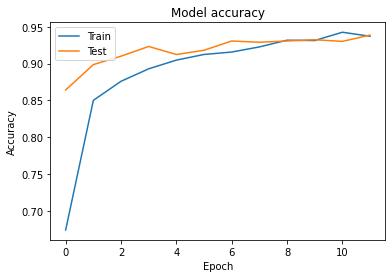

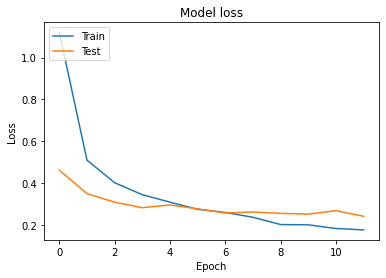

In [15]:
history_plot(my_model)

The error frequency
N :  3
T :  9
M :  6
K :  2
X :  9
Q :  9
O :  2
S :  6
C :  10
D :  1
W :  3
L :  2
P :  4
U :  6
E :  9
A :  1
V :  9
R :  4
G :  3
B :  1
I :  2
Y :  3
H :  3


 In Total:  23 wrong predictions 


Falsely predicted: N




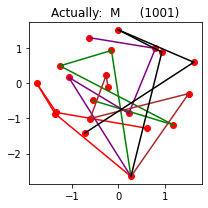

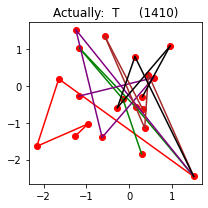

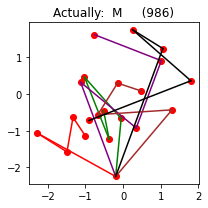




Falsely predicted: T




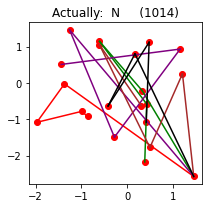

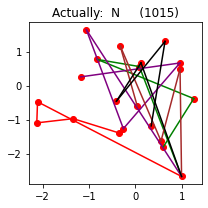

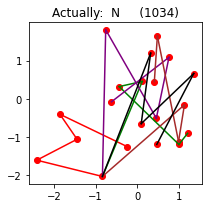

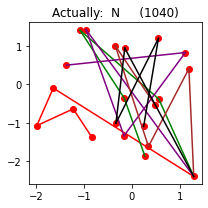

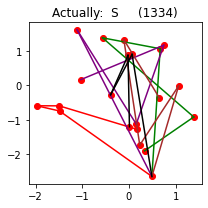

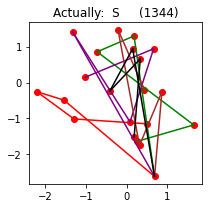

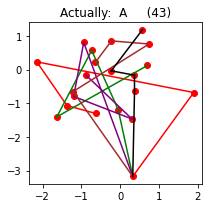

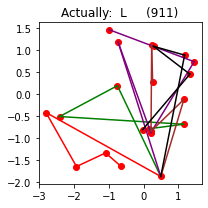

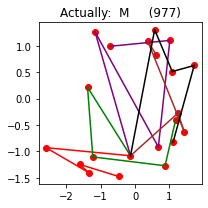




Falsely predicted: M




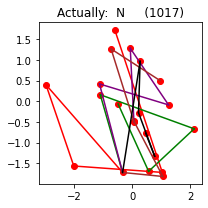

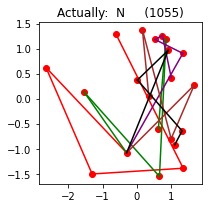

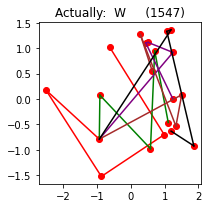

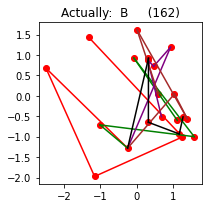

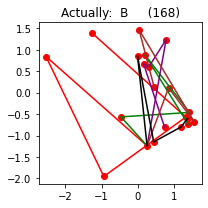

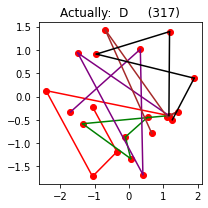




Falsely predicted: K




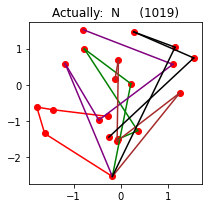

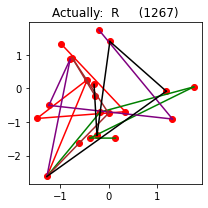




Falsely predicted: X




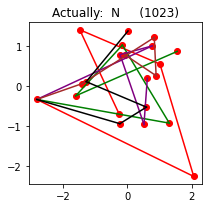

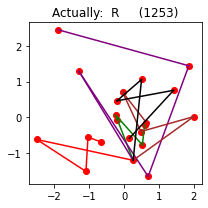

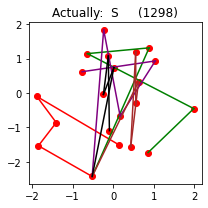

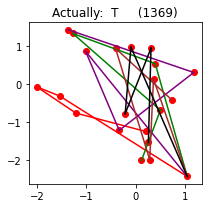

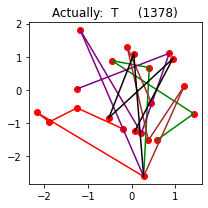

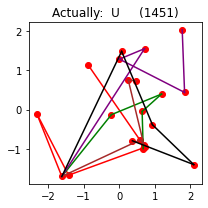

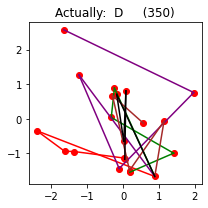

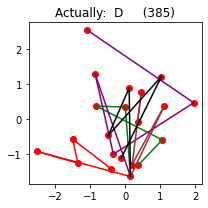

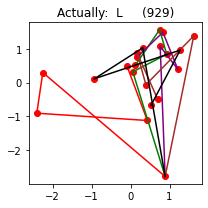




Falsely predicted: Q




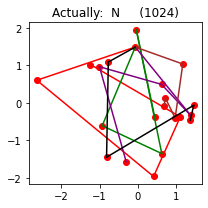

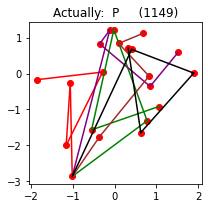

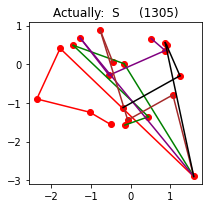

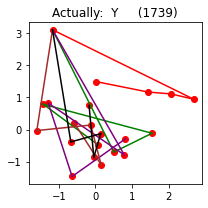

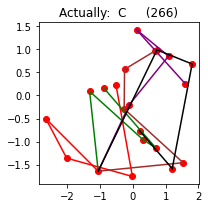

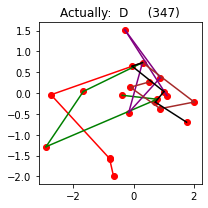

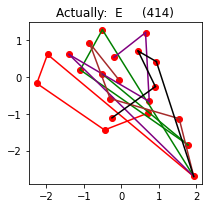

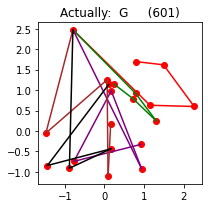

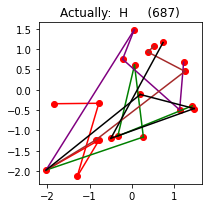




Falsely predicted: O




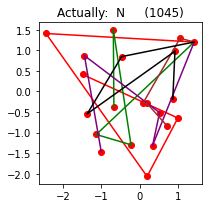

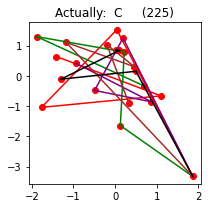




Falsely predicted: S




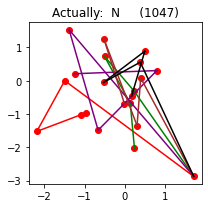

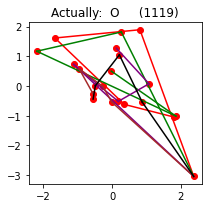

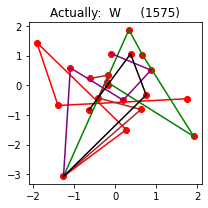

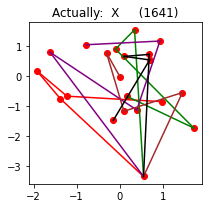

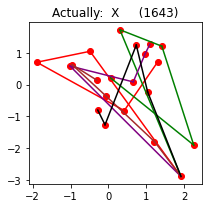

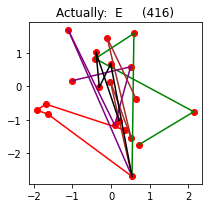




Falsely predicted: C




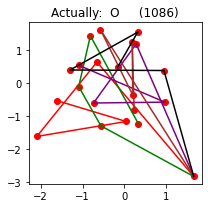

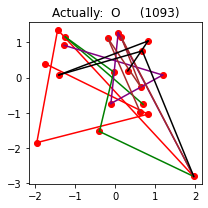

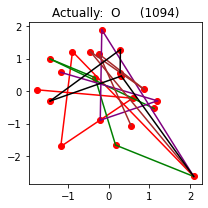

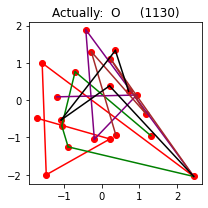

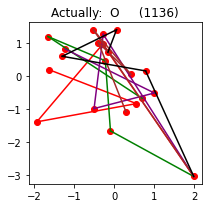

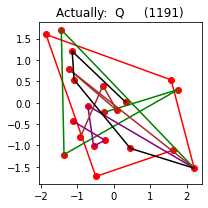

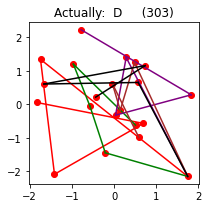

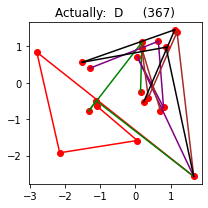

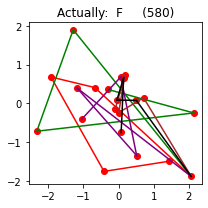

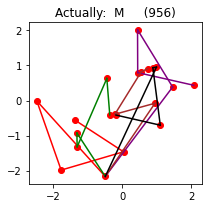




Falsely predicted: D




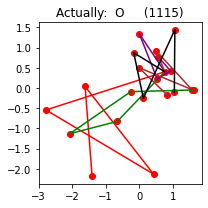




Falsely predicted: W




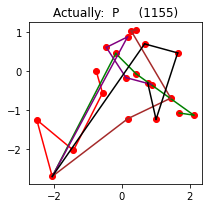

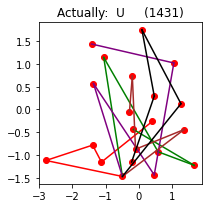

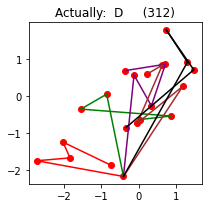




Falsely predicted: L




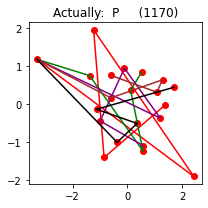

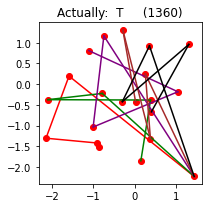




Falsely predicted: P




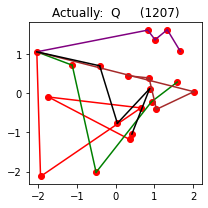

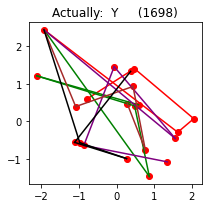

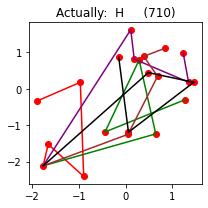

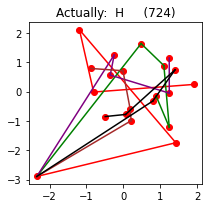




Falsely predicted: U




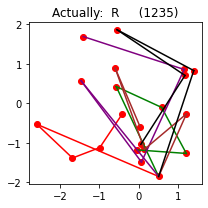

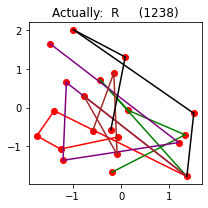

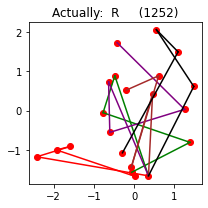

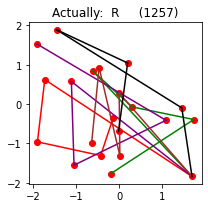

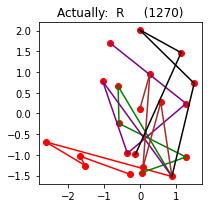

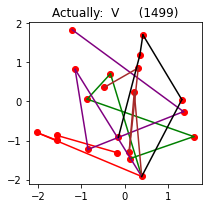




Falsely predicted: E




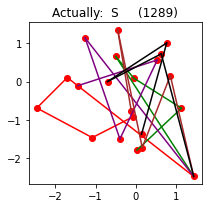

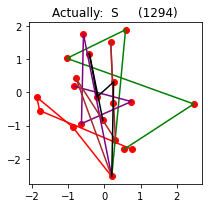

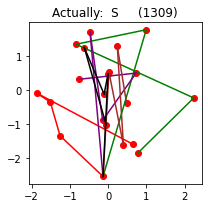

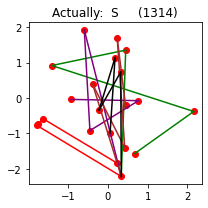

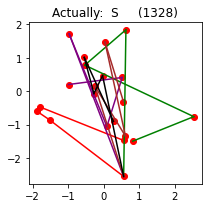

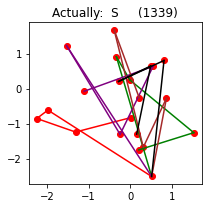

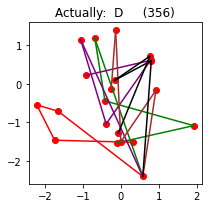

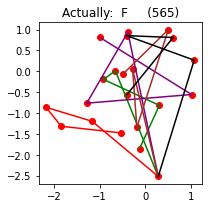

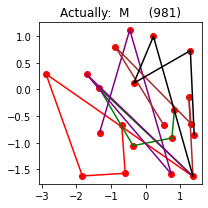




Falsely predicted: A




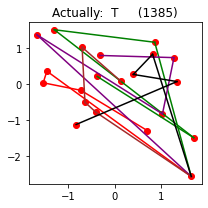




Falsely predicted: V




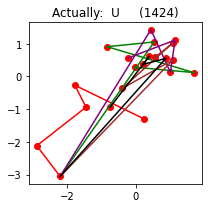

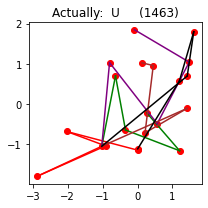

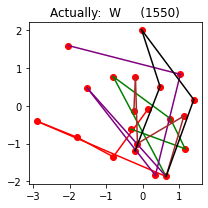

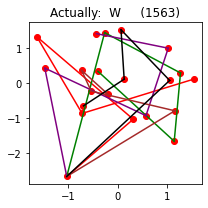

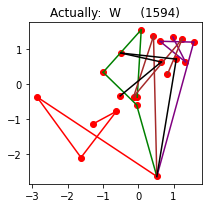

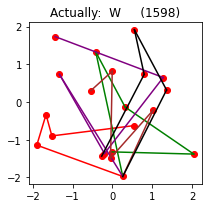

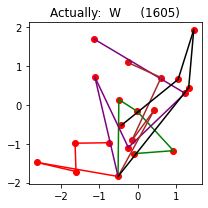

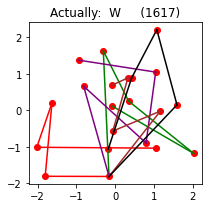

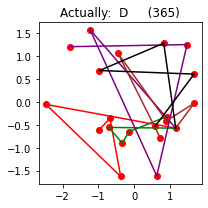




Falsely predicted: R




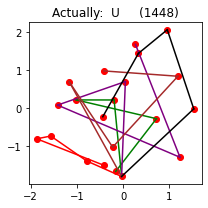

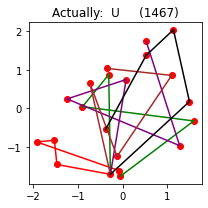

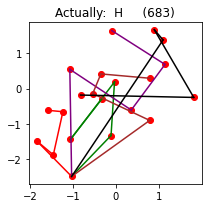

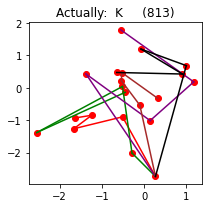




Falsely predicted: G




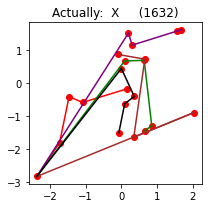

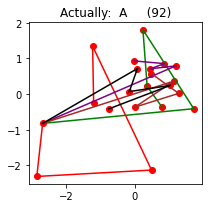

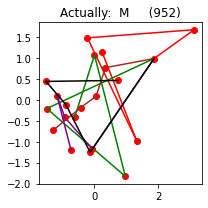




Falsely predicted: B




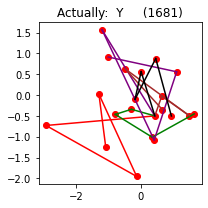




Falsely predicted: I




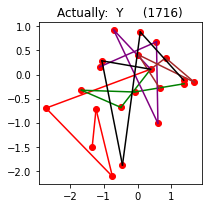

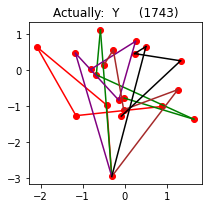




Falsely predicted: Y




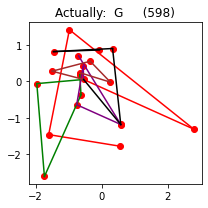

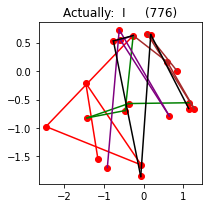

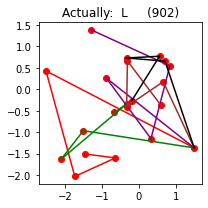




Falsely predicted: H




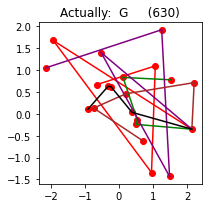

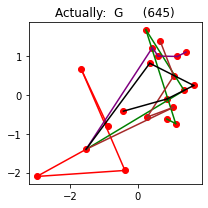

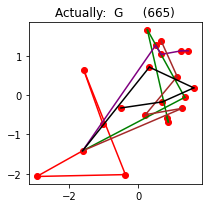




None


In [21]:
print(plot_predict(prediction)) # analize the errors visually

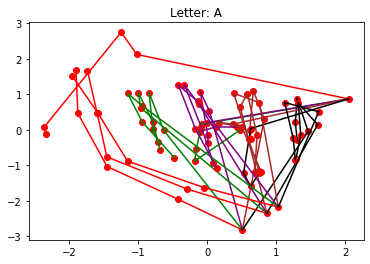

In [ ]:
test.plot_ontop(0,1,2,3) # analize the affect of z_score